<a href="https://colab.research.google.com/github/shabana1408/Prediction-of-Product-Sales/blob/main/Project_1_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 Final

## Requirements

Finalize your sales prediction project. The goal of this is to help the retailer understand the properties of products and outlets that play crucial roles in predicting sales.

1.   Your first task is to build a linear regression model to predict sales.
> - Build a linear regression model.
> - Use the custom evaluation function to get the metrics for your model (on training and test data).
> - Compare the training vs. test R-squared values and answer the question: to what extent is this model overfit/underfit?

2.   Your second task is to build a Random Forest model to predict sales.
> -  Build a default Random Forest model.
> - Use the custom evaluation function to get the metrics for your model (on training and test data).
> - Compare the training vs. test R-squared values and answer the question: to what extent is this model overfit/underfit?
> - Compare this model's performance to the linear regression model: which model has the best test scores?

3.   Use GridSearchCV to tune at least two hyperparameters for a Random Forest model.
> - After determining the best parameters from your GridSearch, fit and evaluate a final best model on the entire training set (no folds).
> - Compare your tuned model to your default Random Forest: did the performance improve?

4.   You now have tried several different models on your data set. You need to determine which model to implement.
> - Overall, which model do you recommend?
> - Justify your recommendation.
> - Interpret your model's performance based on R-squared in a way that your non-technical stakeholder can understand.
> - Select another regression metric (RMSE/MAE/MSE) to express the performance of your model to your stakeholder.
> - Include why you selected this metric to explain to your stakeholder.
> - Compare the training vs. test scores and answer the question: to what extent is this model overfit/underfit?

### Data Dictionary

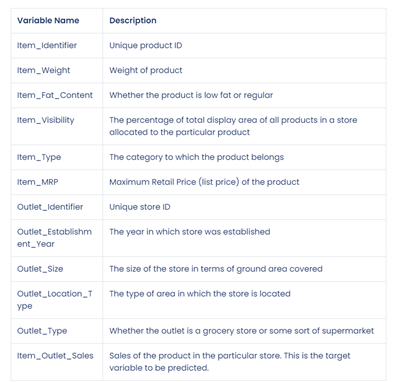

## Imports

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

set_config(transform_output='pandas')

## Custom Functions

In [ ]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

##Load Data

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
fpath = '/content/drive/MyDrive/CodingDojo/02-MachineLearning/Week05/Data/sales_predictions_2023.csv'

df = pd.read_csv(fpath)

## Inspect data

Number of rows and columns:

In [ ]:
df.shape

(8523, 12)



- There are `8 523` rows and `12` columns.


View the data:

In [ ]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


> - There seems to be missing values in the `Item_Weight  ` and `Outlet_Size` columns.
> - Data types seem to be correct.

Summary look at data types:

In [ ]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

 > - There are `5` numerical columns and `7` categorical\string columns.

## Clean Data

**Correcting data types:**

 > - Data types appear to be correct.

**Checking for duplicates:**

In [ ]:
df.duplicated().sum()

0

> - There are `no` duplicates in the data.

**Addressing inconsistent categories of data**

Consider columns with data type object:

In [ ]:
obj_columns = df.select_dtypes('object')
obj_columns

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2
2,FDN15,Low Fat,Meat,OUT049,Medium,Tier 1,Supermarket Type1
3,FDX07,Regular,Fruits and Vegetables,OUT010,NaN,Tier 3,Grocery Store
4,NCD19,Low Fat,Household,OUT013,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...
8518,FDF22,Low Fat,Snack Foods,OUT013,High,Tier 3,Supermarket Type1
8519,FDS36,Regular,Baking Goods,OUT045,NaN,Tier 2,Supermarket Type1
8520,NCJ29,Low Fat,Health and Hygiene,OUT035,Small,Tier 2,Supermarket Type1
8521,FDN46,Regular,Snack Foods,OUT018,Medium,Tier 3,Supermarket Type2


In [ ]:
for i in obj_columns:
  print(i)
  print(df[i].value_counts())
  print('\n')

Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    55

The following inconsistencies where found:

*Item_Fat_Content:*
  - `LF` should be `Low Fat`
  - `low fat` should be `Low Fat`
  - `reg` should be `Regular`

We address this below using a dictionary to replace the inconsistent categories.

In [ ]:
current = ['Low Fat', 'Regular', 'LF', 'reg', 'low fat']
replacement = ['Low Fat', 'Regular', 'Low Fat', 'Regular', 'Low Fat']

rename_dict = dict(zip(current, replacement))
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(rename_dict)

Confirm that the inconsistent values have been addressed:

In [ ]:
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

All inconsistencies have been addressed.

**Summary statistics for numerical columns**

In [ ]:
stats =  df.describe().round(2)
stats.loc[['mean','min','max']]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
mean,12.86,0.07,140.99,1997.83,2181.29
min,4.56,0.00,31.29,1985.00,33.29
max,21.35,0.33,266.89,2009.00,13086.96


> - There seems to be `no` constant numeric values.

**Check for unique entries in columns**

Consider columns with data type object:

In [ ]:
for i in obj_columns:
  print(i)
  print(df[i].nunique())
  print(f'{round(df[i].nunique()/len(df)*100,2)}%')
  print('\n')

Item_Identifier
1559
18.29%


Item_Fat_Content
2
0.02%


Item_Type
16
0.19%


Outlet_Identifier
10
0.12%


Outlet_Size
3
0.04%


Outlet_Location_Type
3
0.04%


Outlet_Type
4
0.05%




> - `No` column has unique values.
> - `Item_Identifier`, `Item_Type`, `Outlet_Identifier` have high cardinality.

**Drop unwanted columns**

> - Drop `Item_Identifier` and `Outlet_Identifier` due to high cardinality.
> - `Item_Type` seems to be valuable based on understanding.
> - Drop `Outlet_Establishment_Year` as the stakeholders have no influence over this.

In [ ]:
drop_cols = ['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year']
df = df.drop(columns = drop_cols)

## Train test split

Our target vector (y) will be the *Item_Outlet_Sales* column.

In [ ]:
y = df['Item_Outlet_Sales']

Our feature matrix (X) will be the rest of the features.

In [ ]:
X = df.drop(columns = 'Item_Outlet_Sales')

Then, train\test split the data:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Column Transformer

**Preprocessing numeric features**

Create a list of numeric columns

In [ ]:
#num_selector = make_column_selector(dtype_include='number')
num_cols = df.select_dtypes('number').columns.drop('Item_Outlet_Sales')
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')

Instantiate preprocessors

In [ ]:
impute_mean = SimpleImputer(strategy='mean')
scaler = StandardScaler()

Create a numeric preprocessing pipeline

In [ ]:
num_pipe = make_pipeline(impute_mean, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

Create a numeric tuple for ColumnTransformer

In [ ]:
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object'))

**Preprocessing ordinal features**

Create a list of ordinal columns

In [ ]:
ord_cols = ['Outlet_Size']

Instantiate preprocesser to impute ordinal data

In [ ]:
impute_na_ord = SimpleImputer(strategy='constant', fill_value='Unknown')

- Specify the order of categories in the *Outlet_Size* column

In [ ]:
outlet_size_order = ['Unknown', 'Small','Medium', 'High']

Instantiate preprocessors

In [ ]:
ordinal_category_orders = [outlet_size_order]
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)

scaler_ord = StandardScaler()

Create an ordinal preprocessing pipeline

In [ ]:
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)
ord_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='Unknown', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Unknown', 'Small', 'Medium',
                                             'High']])),
                ('standardscaler', StandardScaler())])

Create an ordinal tuple for ColumnTransformer

In [ ]:
ord_tuple = ('ordinal', ord_pipe, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='Unknown', strategy='constant')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Unknown', 'Small', 'Medium',
                                              'High']])),
                 ('standardscaler', StandardScaler())]),
 ['Outlet_Size'])

**Preprocessing on categorical (nominal) features**

Create a list of categorical columns

In [ ]:
ohe_cols = df.select_dtypes('object').columns.drop(ord_cols)
ohe_cols

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object')

Instantiate preprocessors

In [ ]:
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

Create a categorical tuple for ColumnTransformer

In [ ]:
ohe_tuple = ('categorical', ohe_encoder, ohe_cols)
ohe_tuple

('categorical',
 OneHotEncoder(handle_unknown='ignore', sparse_output=False),
 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object'))

**Instantiate the ColumnTransformer**

In [ ]:
preprocessor = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple],
                                    verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Unknown',
                                                                              'Small',
                                                                              'Medium',
                                                                              'High']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('categorical',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object'))],
                  verbose_feature_names_out=False)

## Linear Regression Model

Create a model pipeline

In [ ]:
linreg = LinearRegression()

linreg_pipe = make_pipeline(preprocessor, linreg)

Fit the model pipeline on the training data

In [ ]:
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ordinalenco...
                                                                   OrdinalEncoder(categories=[['Unknown',
                                                                                               'Small',
                                                                                               'Medium',
                                                                                               'High']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

Evaluate the model

In [ ]:
evaluate_regression(linreg_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.145
- MSE = 1,299,210.393
- RMSE = 1,139.829
- R^2 = 0.561

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 806.530
- MSE = 1,199,144.239
- RMSE = 1,095.054
- R^2 = 0.565


> - The r<sup>2</sup> for the training and test data is `0.561` and `0.565` respectively.
> - This suggests that the model is explaining around 50% of the variability in the data.
> - This may indicate a balance between underfitting (high bias) and overfitting (high variance).
> - Since both data sets provided similar results, it may suggest consistency in model performance.

## Random Forest Model

Create a model pipeline

In [ ]:
rfreg = RandomForestRegressor(random_state=42)

rf_pipe = make_pipeline(preprocessor, rfreg)

Fit the model pipeline on the training data

In [ ]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ordinalenco...
                                                                                               'Small',
                                                                                               'Medium',
                                                                                               'High']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

Evaluate the model

In [ ]:
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 299.953
- MSE = 187,247.959
- RMSE = 432.722
- R^2 = 0.937

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 776.594
- MSE = 1,258,519.493
- RMSE = 1,121.838
- R^2 = 0.544


> - The r<sup>2</sup> for the training and test data is `0.937` and `0.544` respectively.
> - This suggests that the model is `overfitting` due to the high training r<sup>2</sup> value.
> - The test r<sup>2</sup> indicates that the model explains around 50% of the variability in the test data.
> - Thus, there is some predictive capability on unseen data.

> - The `linear regression` model is the preferred model since it is more balanced.
>- Even though the r<sup>2</sup> is higher for the training data using the random forest model, the drop in performance on the test data indicates that the random forest model is not performing as well as the linear regression model.  

## Use GridSearchCV to tune the Random Forest Model

Consider parameters:

In [ ]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                   ('ordinal',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='Unknown',
                                                                   strategy='constant')),
                                                    ('ordinalencoder',
                                                     OrdinalEncoder(categories=[['Unknown',
                                                  

Define parameter grid

In [ ]:
param_grid = {'randomforestregressor__max_depth': [None,10,15,20],
          'randomforestregressor__n_estimators':[10,100,150,200],
          'randomforestregressor__min_samples_leaf':[2,3,4],
          'randomforestregressor__max_features':['sqrt','log2',None]
          }

Instantiate GridSearchCV

In [ ]:
grid_search = GridSearchCV(rf_pipe, param_grid, cv=2, verbose=1)

Fit to training data

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 144 candidates, totalling 288 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='Unknown',
                                                                                                        strateg...
                                                                         Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'randomforestregressor__max_depth': [None, 10, 15, 20],
                         'randomforestregressor__max_features': ['sqrt', 'log2',
                                                                 None],
                         'randomforestregressor__min_samples_leaf': [2, 3, 4],
                         'randomforestregressor__n_estimators': [10, 100, 150,
                                                                 200]},
             verbose=1)

Return the optimal parameter values:

In [ ]:
grid_search.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__max_features': None,
 'randomforestregressor__min_samples_leaf': 4,
 'randomforestregressor__n_estimators': 200}

Define the best version of the model

In [ ]:
best_rf = grid_search.best_estimator_

Evaluate the best version of the model

In [ ]:
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 662.941
- MSE = 895,161.158
- RMSE = 946.130
- R^2 = 0.698

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 735.963
- MSE = 1,116,665.330
- RMSE = 1,056.724
- R^2 = 0.595


>- The r<sup>2</sup> for the training data decreased from `0.937` to `0.698` indicating that the tuned model is less prone to overfitting.
> - The r<sup>2</sup> for the test data improved slightly from `0.544` to `0.595` indicating that the tuned model performs better on unseen data, compared to the default model, i.e. better generalization.
> - Thus, tuning `improved` the random forest models performance.

Overall, which model do you recommend?
> - The `tuned random forest model`: The r<sup>2</sup> for the test data (`0.595`) is higher than that of the linear regression model (`0.565`), indicating better generalization and predictive performance on unseen data.

For non-technical stakeholder:

>- The random forest regression model is able to accurately explain 60% of the variability in the data, i.e. our models prediction matches actual outcomes 60% of the time.

> - Also consider the RMSE (Root Mean Squared Error) becuase it is easy to interpret and accounts for the size of prediction errors.

> - On average, the model's predictions are off by `1 057 (rounded)` units compared to the actual values.

To what extent is this model overfit/underfit?
> - The r<sup>2</sup> on the training data (`0.698`) is higher than on the test data (`0.595`). However the gap is not too large and may be expected.
> - The MSE (Mean Squared Error) on the training data (`895 161`) is 25% lower than the MSE (`1 116 665`) on the test data. This may indicate that the model is fitting the training data too well.
> - The model may be `overfit`.